In [1]:
# !pip install timeseries-cv
# !pip install pyunlocbox -qqq
# !pip install pygsp -qqq

from graph_learning_algorithm import learn_connected_graph, LapInv
import numpy as np
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet, MultiTaskElasticNetCV, MultiTaskLassoCV, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor
import scipy
from sklearn.covariance import graphical_lasso
from collections import defaultdict
from tsxv.splitTrain import split_train, split_train_variableInput
import itertools
from tqdm.notebook import tqdm
from dask.distributed import Client
import copy
from learn_graph_kalofolias import log_degree_barrier, l2_degree_reg
from backtesting import *
client = Client(processes=False)
client

Client Scheduler: inproc://192.168.1.5/23260/1 Dashboard: http://192.168.1.5:8787/status,Cluster Workers: 1 Cores: 12 Memory: 15.37 GiB


# Load Data

In [2]:
prices = pd.read_csv("data/prices_CRSP.csv")
prices['datadate'] = prices['datadate'].astype(str).str[:-2]
prices = prices.rename(columns={'datadate': 'year_month'}).set_index('year_month')
prices
# prices['month'] = prices['datadate'].dt.month
# prices['year'] = prices['datadate'].dt.year

,1010,1034,1040,1054,1062,1075,1076,1078,1119,1128,...,264647,264686,264708,266214,268208,269005,277812,287462,287882,294524
year_month,,,,,,,,,,,,,,,,,,,,,
196206,59.00,NaN,22.250,NaN,NaN,25.75,NaN,63.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196207,67.48,NaN,21.000,NaN,NaN,28.00,NaN,63.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196208,67.12,NaN,21.750,NaN,NaN,28.75,NaN,58.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196209,63.48,NaN,19.500,NaN,NaN,28.00,NaN,60.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196210,68.00,NaN,18.125,NaN,NaN,26.63,NaN,64.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202206,NaN,NaN,NaN,NaN,14.67,73.12,16.50,108.65,15.34,NaN,...,8.8000,25.31,NaN,63.59,15.12,NaN,11.88,7.28,10.86,87.46
202207,NaN,NaN,NaN,NaN,15.13,73.47,18.42,108.84,16.64,NaN,...,9.3900,27.55,NaN,73.69,16.34,NaN,8.88,7.19,10.74,89.12
202208,NaN,NaN,NaN,NaN,13.99,75.35,18.54,102.65,16.07,NaN,...,9.1300,26.65,NaN,71.38,16.45,NaN,7.77,7.29,10.31,83.00


In [3]:
monthly_log_returns = np.log2(prices).diff().iloc[1:]#.shift(-1).iloc[:-1]
monthly_log_returns

,1010,1034,1040,1054,1062,1075,1076,1078,1119,1128,...,264647,264686,264708,266214,268208,269005,277812,287462,287882,294524
year_month,,,,,,,,,,,,,,,,,,,,,
196207,0.193745,NaN,-0.083416,NaN,NaN,0.120854,NaN,-0.005714,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196208,-0.007717,NaN,0.050626,NaN,NaN,0.038135,NaN,-0.119299,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196209,-0.080441,NaN,-0.157541,NaN,NaN,-0.038135,NaN,0.054908,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196210,0.099233,NaN,-0.105493,NaN,NaN,-0.072374,NaN,0.103919,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196211,0.099986,NaN,0.212408,NaN,NaN,0.178148,NaN,0.107313,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202206,NaN,NaN,NaN,NaN,-0.318186,-0.086720,-0.823008,-0.112481,-0.114754,NaN,...,-0.218711,-0.138488,NaN,-0.261180,-0.143390,NaN,-0.116598,0.017947,-0.637999,-0.385499
202207,NaN,NaN,NaN,NaN,0.044543,0.006889,0.158807,0.002521,0.117357,NaN,...,0.093622,0.122345,NaN,0.212669,0.111950,NaN,-0.419903,-0.017947,-0.016030,0.027126
202208,NaN,NaN,NaN,NaN,-0.113016,0.036452,0.009368,-0.084475,-0.050286,NaN,...,-0.040510,-0.047917,NaN,-0.045949,0.009680,NaN,-0.192645,0.019927,-0.058950,-0.102638


# Load the factors and evaluate residuals

In [4]:
factors = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)
factors = factors[factors['Date'].astype(str).str.strip().str.len() == 6]
factors = factors.set_index('Date')
factors.columns += '_factor'
factors = factors.astype(np.float64)
factors

,Mkt-RF_factor,SMB_factor,HML_factor,RMW_factor,CMA_factor,RF_factor
Date,,,,,,
196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
196308,5.07,-0.80,1.80,0.36,-0.35,0.25
196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
202205,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,9.57,1.88,-4.10,0.68,-6.94,0.08


In [5]:
returns_factors_merged = monthly_log_returns.merge(factors, right_index=True, left_index=True, suffixes=['', '_factor'])
returns_factors_merged

,1010,1034,1040,1054,1062,1075,1076,1078,1119,1128,...,277812,287462,287882,294524,Mkt-RF_factor,SMB_factor,HML_factor,RMW_factor,CMA_factor,RF_factor
196307,-0.068842,NaN,-0.205810,NaN,NaN,0.023847,NaN,0.200299,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.39,-0.41,-0.97,0.68,-1.18,0.27
196308,0.141354,NaN,0.065434,NaN,NaN,0.130175,NaN,0.145978,NaN,NaN,...,NaN,NaN,NaN,NaN,5.07,-0.80,1.80,0.36,-0.35,0.25
196309,-1.102568,NaN,-0.114742,NaN,NaN,-0.043881,NaN,-0.032105,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.57,-0.52,0.13,-0.71,0.29,0.27
196310,0.080909,NaN,-0.020043,NaN,NaN,-0.080158,NaN,-0.087401,NaN,NaN,...,NaN,NaN,NaN,NaN,2.53,-1.39,-0.10,2.80,-2.01,0.29
196311,0.309237,NaN,0.020043,NaN,NaN,0.040406,NaN,0.067263,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202205,NaN,NaN,NaN,NaN,-0.168785,0.125109,0.141116,0.049477,-0.017268,NaN,...,0.263483,-0.403454,0.058360,0.107722,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,NaN,NaN,NaN,NaN,-0.318186,-0.086720,-0.823008,-0.112481,-0.114754,NaN,...,-0.116598,0.017947,-0.637999,-0.385499,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,NaN,NaN,NaN,NaN,0.044543,0.006889,0.158807,0.002521,0.117357,NaN,...,-0.419903,-0.017947,-0.016030,0.027126,9.57,1.88,-4.10,0.68,-6.94,0.08
202208,NaN,NaN,NaN,NaN,-0.113016,0.036452,0.009368,-0.084475,-0.050286,NaN,...,-0.192645,0.019927,-0.058950,-0.102638,-3.78,1.51,0.31,-4.80,1.31,0.19


# Cross Validation

In [6]:
X, y = split_train(returns_factors_merged.index.values, numInputs=24, numOutputs=12, numJumps=1)

In [7]:
returns_factors_merged_split_train = returns_factors_merged.loc[X[0]]
returns_factors_merged_split_test = returns_factors_merged.loc[y[0]]

factors_split_train = returns_factors_merged_split_train[factors.columns]
returns_split_train = returns_factors_merged_split_train.drop(columns=factors.columns)

factors_split_test = returns_factors_merged_split_test[factors.columns]
returns_split_test = returns_factors_merged_split_test.drop(columns=factors.columns)

not_na_columns = ~returns_split_train.isna().any(axis=0)
returns_split_train = returns_split_train.loc[:, not_na_columns]
returns_split_test = returns_split_test.loc[:, not_na_columns]
returns_split_train.head()

,1010,1040,1075,1078,1157,1209,1215,1221,1243,1279,...,11550,11555,11559,11609,12564,13499,14331,15106,28590,30865
196307,-0.068842,-0.205810,0.023847,0.200299,-0.114430,-0.027193,-0.023274,-0.010344,-0.107211,0.000000,...,-0.036366,0.036158,-0.004578,0.047668,0.005588,-0.050465,0.084392,-0.185024,-0.100328,-0.083636
196308,0.141354,0.065434,0.130175,0.145978,-0.010244,0.111484,0.092461,-0.015258,0.000000,0.170429,...,0.048287,0.012065,0.069925,-0.036527,0.021292,0.171480,0.205904,0.082501,0.028592,0.049101
196309,-1.102568,-0.114742,-0.043881,-0.032105,-0.045251,-0.054665,-0.038903,0.010457,0.093405,-0.167030,...,0.000000,-0.064662,-0.004923,0.011055,-0.026879,-0.121015,-0.065423,-0.175544,-0.123989,-0.006680
196310,0.080909,-0.020043,-0.080158,-0.087401,-0.070209,-0.078326,0.048086,0.260360,-0.028014,0.055495,...,-0.085594,0.044605,-0.050740,0.025472,-0.021695,0.057450,0.072512,0.029040,0.060373,-0.007260
196311,0.309237,0.020043,0.040406,0.067263,-0.024788,0.078326,-0.018939,0.025203,-0.043069,-0.062300,...,-0.045040,-0.024248,0.139459,-0.032833,-0.049814,-0.084758,-0.072512,0.115477,-0.011898,-0.049586


In [8]:
residuals_methods = ['residuals']
spreads_methods = {
    # Identity
    'Identity': compute_identity_L(),
    # Top-k correlations
    'Corr-50': compute_corr_L(50),
    # Smooth graph signals
    'SGS laplacian_root=True, adjust_laplacian=False': compute_SGS_L(laplacian_root=True, adjust_laplacian=True),
    # Laplacian constrained gaussian markov random field
    'LGMRF laplacian_root=True, adjust_laplacian=False': compute_LGMRF_L(laplacian_root=True, adjust_laplacian=False),
}

trading_type = ['long', 'short', 'both']
windows = [1, 2]
gammas = [None, 2]
quantiles = [0.2, 0.1]

trading_methods = {f'Quantile-std w={_w} q={_q} gamma={_g} {_t_type}': quantiles_std_trading_rule(q=_q, w=_w, trading_type=_t_type, gamma=_g)
                        for (_w, _q, _g), _t_type in itertools.product(zip(windows, quantiles, gammas), trading_type)}

X, y = split_train(returns_factors_merged.index.values, numInputs=60, numOutputs=12+1, numJumps=1)
futures = client.map(lambda idx: evaluate_split_returns_from_idx(returns_factors_merged, factors.columns, idx_tuple=idx,
                                                                 residuals_method_names=residuals_methods, 
                                                                 spreads_methods=spreads_methods, 
                                                                 trading_methods=trading_methods), 
                     list(zip(X, y))[::12])
results = client.gather(futures)

In [9]:
split_returns_df = pd.concat(results)
# split_returns_df['compl_avg_month_returns'] = np.real(split_returns_df['compl_avg_month_returns'])
# split_returns_df['pairs_avg_month_returns'] = np.real(split_returns_df['pairs_avg_month_returns'])
split_returns_df['config'] = split_returns_df['residuals_method'] + ' - '+ split_returns_df['spreads_method'] + ' - ' + split_returns_df['trading_method']
split_returns_df['residuals_method_name'] = split_returns_df['residuals_method'].str.split(expand=True)[0]
split_returns_df['trading_method_name'] = split_returns_df['trading_method'].str.split(expand=True)[0]
split_returns_df['spreads_method_name'] = split_returns_df['spreads_method'].str.split(expand=True)[0]
split_returns_df['date'] = pd.to_datetime(split_returns_df['index'].str[:4] + '-' + split_returns_df['index'].str[4:] + '-01')
split_returns_df

,index,avg_month_returns,compl_avg_month_returns,pairs_avg_month_returns,n_positions_avg,n_positions_compl,n_positions_pair,benchmark,trading_method,spreads_method,residuals_method,config,residuals_method_name,trading_method_name,spreads_method_name,date
0,196807,0.019745,0.000000,0.009872,41,0,41,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,residuals,residuals - Identity - Quantile-std w=1 q=0.2 ...,residuals,Quantile-std,Identity,1968-07-01
1,196808,0.041832,0.000000,0.020916,41,0,41,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,residuals,residuals - Identity - Quantile-std w=1 q=0.2 ...,residuals,Quantile-std,Identity,1968-08-01
2,196809,0.013270,0.000000,0.006635,41,0,41,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,residuals,residuals - Identity - Quantile-std w=1 q=0.2 ...,residuals,Quantile-std,Identity,1968-09-01
3,196810,0.098040,0.000000,0.049020,41,0,41,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,residuals,residuals - Identity - Quantile-std w=1 q=0.2 ...,residuals,Quantile-std,Identity,1968-10-01
4,196811,-0.055290,0.000000,-0.027645,41,0,41,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,residuals,residuals - Identity - Quantile-std w=1 q=0.2 ...,residuals,Quantile-std,Identity,1968-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,202202,0.014200,0.014200,0.014200,1242,1242,1242,True,Quantile-std w=2 q=0.1 gamma=2 both,"LGMRF laplacian_root=True, adjust_laplacian=False",residuals,"residuals - LGMRF laplacian_root=True, adjust_...",residuals,Quantile-std,LGMRF,2022-02-01
8,202203,-0.098196,-0.098196,-0.098196,1242,1242,1242,True,Quantile-std w=2 q=0.1 gamma=2 both,"LGMRF laplacian_root=True, adjust_laplacian=False",residuals,"residuals - LGMRF laplacian_root=True, adjust_...",residuals,Quantile-std,LGMRF,2022-03-01
9,202204,0.012641,0.012641,0.012641,1242,1242,1242,True,Quantile-std w=2 q=0.1 gamma=2 both,"LGMRF laplacian_root=True, adjust_laplacian=False",residuals,"residuals - LGMRF laplacian_root=True, adjust_...",residuals,Quantile-std,LGMRF,2022-04-01
10,202205,-0.133434,-0.133434,-0.133434,1242,1242,1242,True,Quantile-std w=2 q=0.1 gamma=2 both,"LGMRF laplacian_root=True, adjust_laplacian=False",residuals,"residuals - LGMRF laplacian_root=True, adjust_...",residuals,Quantile-std,LGMRF,2022-05-01


In [10]:
split_returns_df.to_pickle('data/results_CRSP.pkl')

In [ ]:
trading_returns = split_returns_df[split_returns_df['benchmark'] == False].pivot_table(values='avg_month_returns', columns='config', index='index')
# trading_returns = split_returns_df[split_returns_df['benchmark'] == False].pivot_table(values='compl_avg_month_returns', columns='config', index='index')
# trading_returns = split_returns_df[split_returns_df['benchmark'] == False].pivot_table(values='pairs_avg_month_returns', columns='config', index='index')
trading_returns *= np.sign(trading_returns.mean())
trading_returns
trading_returns.index = factors.loc[trading_returns.index[1]:].iloc[:len(trading_returns)].index
K = 5
top_mean_configs = trading_returns.mean().sort_values(ascending=False).iloc[:K].index.values
top_sharpe_configs = (trading_returns.mean() / trading_returns.std()).sort_values(ascending=False).iloc[:K].index.values

trading_returns_lm = LinearRegression(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
trading_alphas = pd.Series(trading_returns_lm.intercept_, index=trading_returns.columns, name='alpha').sort_values(ascending=False)
top_alpha_configs = trading_alphas.iloc[:K].index.values
top_configs = set(top_mean_configs.tolist() + top_sharpe_configs.tolist() + top_alpha_configs.tolist())

In [14]:
trading_returns_mean = trading_returns.mean().reset_index()
#trading_returns_mean = (trading_returns.mean() / trading_returns.std()).fillna(0).reset_index()
# trading_returns_mean = trading_alphas.reset_index().rename(columns={'alpha': 0})
trading_returns_mean[['data', 'graph', 'trading']] = trading_returns_mean['config'].str.split(' - ', expand=True)
trading_returns_mean[['trading', 'w', 'q', 'gamma', 'type']] = trading_returns_mean['trading'].str.split(' ', expand=True)
trading_returns_mean['w'] = trading_returns_mean['w'].str.split('=', expand=True)[1].astype(int)
trading_returns_mean['q'] = trading_returns_mean['q'].str.split('=', expand=True)[1].astype(float)
trading_returns_mean['gamma'] = trading_returns_mean['gamma'].str.split('=', expand=True)[1].astype(float)
trading_returns_mean['data'] = trading_returns_mean['data'].map(dict(zip(trading_returns_mean['data'].unique(), 
                                                                         range(trading_returns_mean['data'].nunique()))))
trading_returns_mean['graph'] = trading_returns_mean['graph'].map(dict(zip(trading_returns_mean['graph'].unique(), 
                                                                         range(trading_returns_mean['graph'].nunique()))))
trading_returns_mean['type'] = trading_returns_mean['type'].map(dict(zip(trading_returns_mean['type'].unique(), 
                                                                         range(trading_returns_mean['type'].nunique()))))
trading_returns_mean = trading_returns_mean.drop(columns=['config', 'trading']).rename(columns={0: 'mean'})
trading_returns_mean

,mean,data,graph,w,q,gamma,type
0,0.025119,0,0,1,0.2,0.0,0
1,0.012062,0,0,1,0.2,0.0,1
2,0.008811,0,0,1,0.2,0.0,2
3,0.014327,0,0,12,1.0,2.0,0
4,0.008365,0,0,12,1.0,2.0,1
5,0.005963,0,0,12,1.0,2.0,2
6,0.014228,0,0,24,1.0,2.0,0
7,0.008301,0,0,24,1.0,2.0,1
8,0.005926,0,0,24,1.0,2.0,2
9,0.024266,0,1,1,0.2,0.0,0


(0.9991007097651675, 1.0)

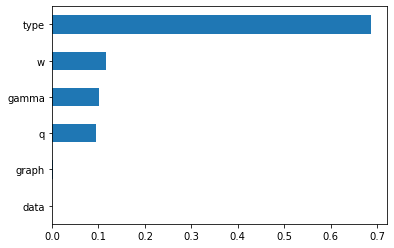

In [15]:
rf = RandomForestRegressor().fit(trading_returns_mean.iloc[:, 1:], trading_returns_mean.iloc[:, 0])
pd.Series(rf.feature_importances_, index=trading_returns_mean.iloc[:, 1:].columns).sort_values().plot.barh()
rf.score(trading_returns_mean.iloc[:, 1:], trading_returns_mean.iloc[:, 0]), rf.feature_importances_.sum()

In [16]:
# trading_alphas
# trading_returns
trading_returns.mean().sort_values(ascending=False).head()

config
residuals - LGMRF laplacian_root=True, adjust_laplacian=False - Quantile-std w=1 q=0.2 gamma=0 both    0.025192
residuals - Corr-50 - Quantile-std w=1 q=0.2 gamma=0 both                                              0.025119
residuals - Identity - Quantile-std w=1 q=0.2 gamma=0 both                                             0.024266
residuals - SGS laplacian_root=True, adjust_laplacian=False - Quantile-std w=1 q=0.2 gamma=0 both      0.024265
residuals - Corr-50 - Quantile-std w=12 q=1.0 gamma=2 both                                             0.014327
dtype: float64

In [17]:
trading_alphas_mean = trading_alphas.reset_index().set_index('config').copy()
trading_alphas_mean['mean'] = trading_returns.mean()
2 ** (trading_alphas_mean.sort_values('alpha', ascending=False).head(7) * 12) - 1
# trading_alphas_mean.sort_values('alpha', ascending=False).head(7)

,alpha,mean
config,,
"residuals - LGMRF laplacian_root=True, adjust_laplacian=False - Quantile-std w=1 q=0.2 gamma=0 short",0.146838,0.078069
residuals - Corr-50 - Quantile-std w=1 q=0.2 gamma=0 short,0.146374,0.076042
"residuals - LGMRF laplacian_root=True, adjust_laplacian=False - Quantile-std w=1 q=0.2 gamma=0 both",0.140824,0.233113
residuals - Identity - Quantile-std w=1 q=0.2 gamma=0 short,0.139869,0.071907
"residuals - SGS laplacian_root=True, adjust_laplacian=False - Quantile-std w=1 q=0.2 gamma=0 short",0.139869,0.071907
residuals - Corr-50 - Quantile-std w=1 q=0.2 gamma=0 both,0.137918,0.232364
residuals - Identity - Quantile-std w=1 q=0.2 gamma=0 both,0.135856,0.223653


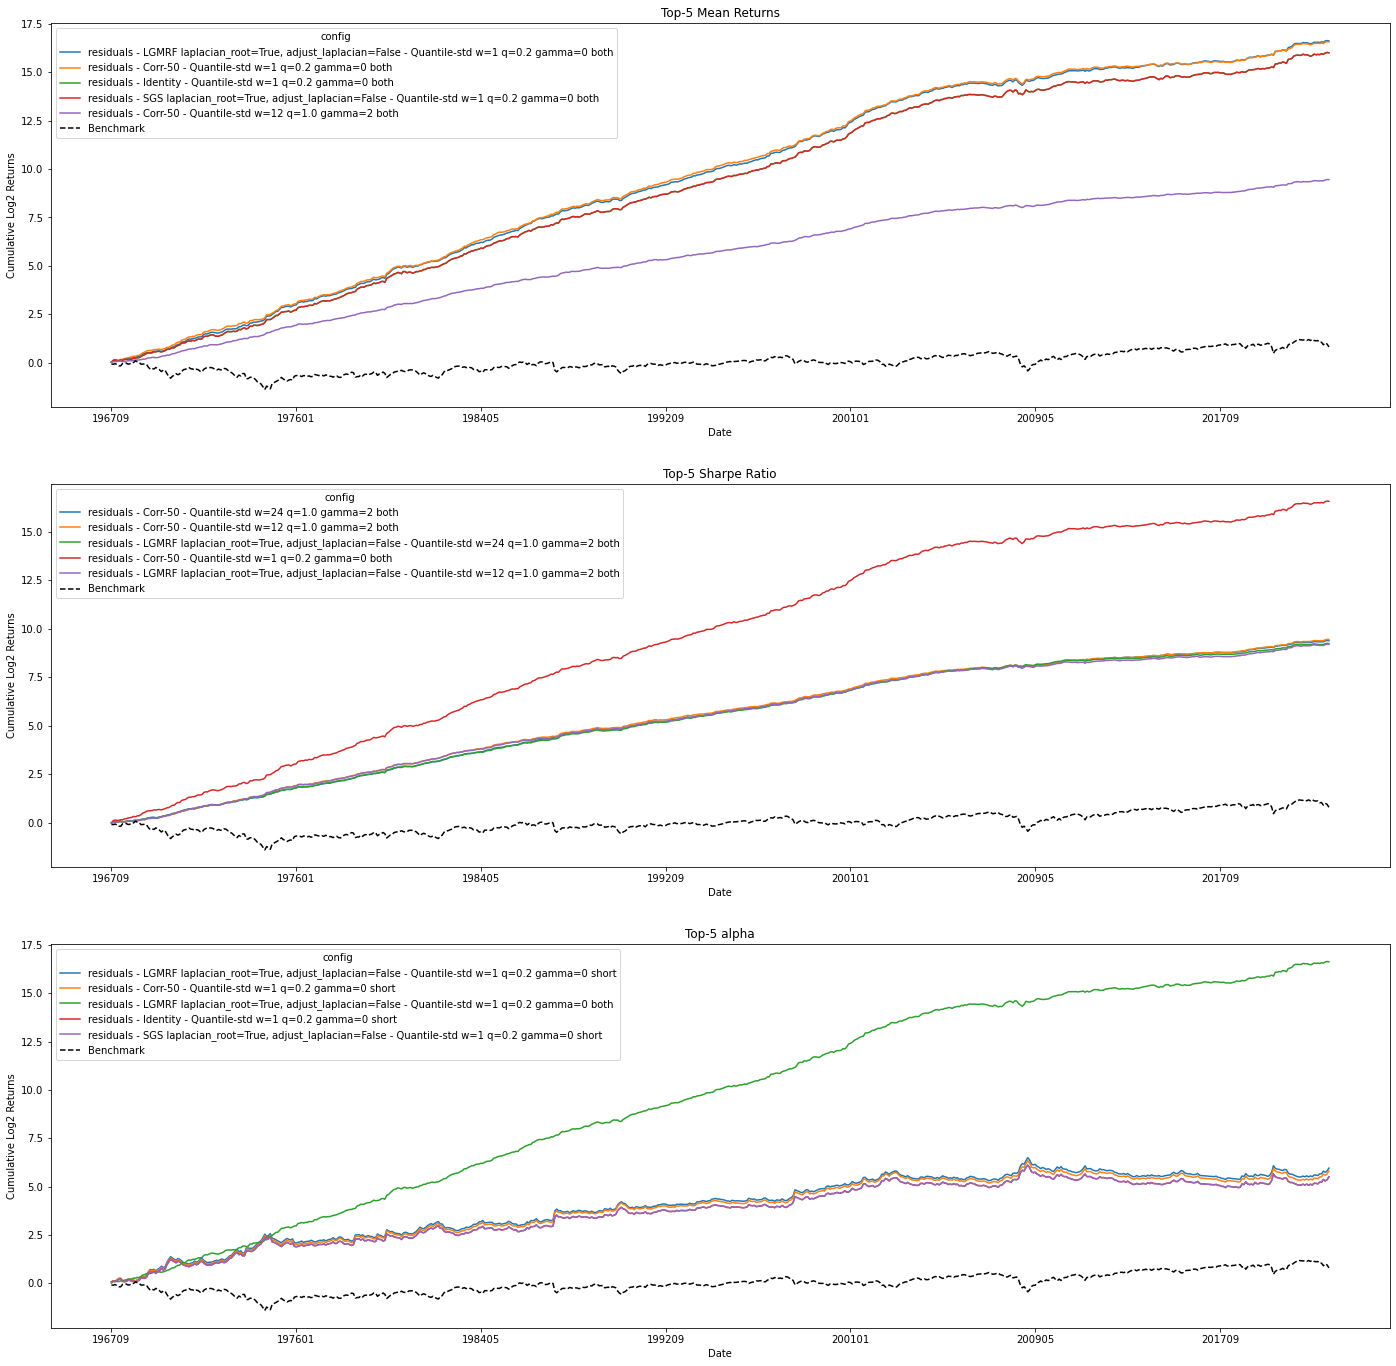

In [18]:
fig, axs =plt.subplots(3, figsize=(24, 24))
trading_returns[top_mean_configs].cumsum().plot(ax=axs[0])
split_returns_df[(split_returns_df['config'] == top_mean_configs[0]) & split_returns_df['benchmark']][['index', 'avg_month_returns']].set_index('index').rename(columns={'avg_month_returns': 'Benchmark'}).cumsum().plot(color='black', ls='--', ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Cumulative Log2 Returns')
axs[0].set_title('Top-5 Mean Returns')
trading_returns[top_sharpe_configs].cumsum().plot(ax=axs[1])
split_returns_df[(split_returns_df['config'] == top_mean_configs[0]) & split_returns_df['benchmark']][['index', 'avg_month_returns']].set_index('index').rename(columns={'avg_month_returns': 'Benchmark'}).cumsum().plot(color='black', ls='--', ax=axs[1])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Cumulative Log2 Returns')
axs[1].set_title('Top-5 Sharpe Ratio')
trading_returns[top_alpha_configs].cumsum().plot(ax=axs[2])
split_returns_df[(split_returns_df['config'] == top_mean_configs[0]) & split_returns_df['benchmark']][['index', 'avg_month_returns']].set_index('index').rename(columns={'avg_month_returns': 'Benchmark'}).cumsum().plot(color='black', ls='--', ax=axs[2])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Cumulative Log2 Returns')
axs[2].set_title('Top-5 alpha')
plt.show()

In [19]:
idx_alpha, _ = split_train(trading_returns.index.values, numInputs=24, numOutputs=0, numJumps=1)
intercepts = []
for idx in idx_alpha:
    intercepts.append(LinearRegression(fit_intercept=True).fit(factors.loc[idx], trading_returns.loc[idx]).intercept_)

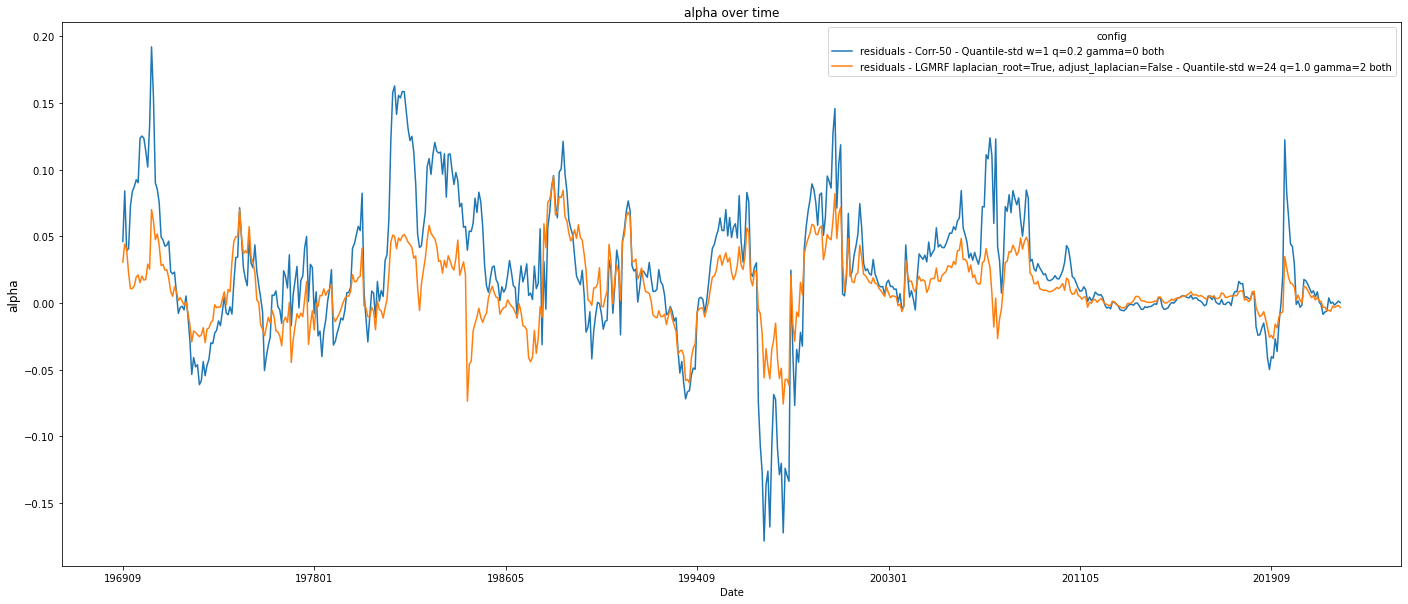

In [20]:
fig, ax =plt.subplots(figsize=(24, 10))
alpha_df = pd.DataFrame(np.array(intercepts), index=trading_returns.index[23:], columns=trading_returns.columns)
alpha_df.iloc[:, ::24].plot(ax=ax)
ax.set_title('alpha over time')
ax.set_ylabel('alpha', fontsize=12)
plt.show()

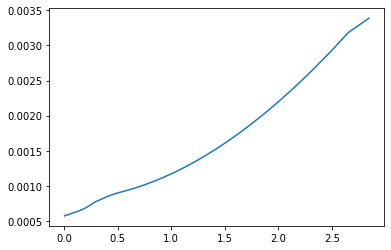

Best Alpha: 0.0028458170692846167


,config,alpha
0,"residuals - LGMRF laplacian_root=True, adjust_...",0.011483
1,residuals - Corr-50 - Quantile-std w=1 q=0.2 g...,0.011449
2,"residuals - LGMRF laplacian_root=True, adjust_...",0.011040
3,residuals - Identity - Quantile-std w=1 q=0.2 ...,0.010969
5,residuals - Corr-50 - Quantile-std w=1 q=0.2 g...,0.010825
6,residuals - Identity - Quantile-std w=1 q=0.2 ...,0.010672
7,"residuals - SGS laplacian_root=True, adjust_la...",0.010670
8,residuals - Corr-50 - Quantile-std w=24 q=1.0 ...,0.010164
9,residuals - Corr-50 - Quantile-std w=12 q=1.0 ...,0.010045
10,"residuals - LGMRF laplacian_root=True, adjust_...",0.009891


In [21]:
trading_returns_lm = MultiTaskElasticNetCV(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
plt.plot(trading_returns_lm.alphas_, trading_returns_lm.mse_path_.mean(axis=-1))
plt.show()
best_alpha = trading_returns_lm.alphas_[trading_returns_lm.mse_path_.mean(axis=-1).argmin()]
print(f'Best Alpha: {best_alpha}')
trading_returns_lm = LinearRegression(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
pd.Series(2**trading_returns_lm.intercept_ - 1, index=trading_returns.columns, name='alpha').sort_values(ascending=False).reset_index().drop_duplicates('alpha').head(15)

In [22]:
trading_returns_lm = LinearRegression(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
# trading_returns_lm = ElasticNet(alpha = best_alpha, fit_intercept = True).fit(factors.loc[trading_returns.index], trading_returns)
# trading_returns_lm = Lasso(alpha = 0.185, fit_intercept = True).fit(factors.loc[trading_returns.index], trading_returns)
pd.Series(2**trading_returns_lm.intercept_ - 1, index=trading_returns.columns, name='alpha').sort_values(ascending=False).reset_index().drop_duplicates('alpha').head(15)

,config,alpha
0,"residuals - LGMRF laplacian_root=True, adjust_...",0.011483
1,residuals - Corr-50 - Quantile-std w=1 q=0.2 g...,0.011449
2,"residuals - LGMRF laplacian_root=True, adjust_...",0.011040
3,residuals - Identity - Quantile-std w=1 q=0.2 ...,0.010969
5,residuals - Corr-50 - Quantile-std w=1 q=0.2 g...,0.010825
6,residuals - Identity - Quantile-std w=1 q=0.2 ...,0.010672
7,"residuals - SGS laplacian_root=True, adjust_la...",0.010670
8,residuals - Corr-50 - Quantile-std w=24 q=1.0 ...,0.010164
9,residuals - Corr-50 - Quantile-std w=12 q=1.0 ...,0.010045
10,"residuals - LGMRF laplacian_root=True, adjust_...",0.009891


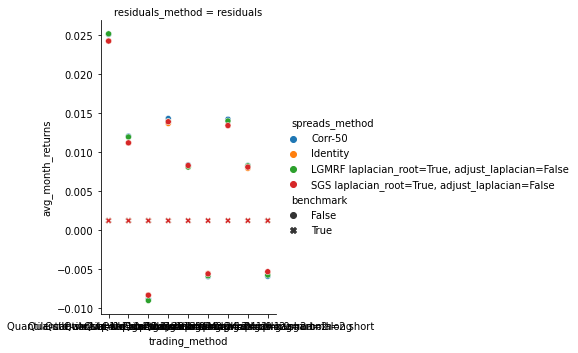

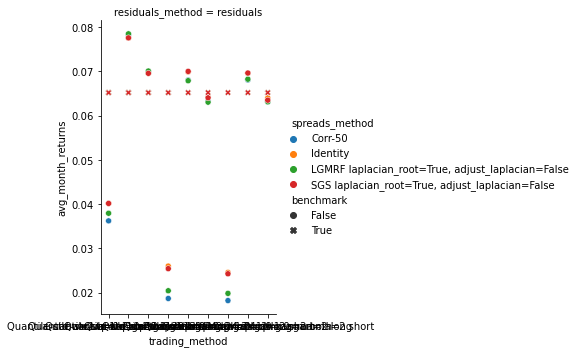

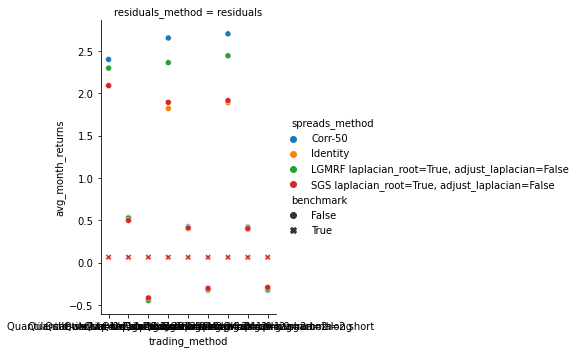

In [23]:
grouped_split_results = split_returns_df.groupby(['trading_method', 'spreads_method', 'residuals_method', 'benchmark'])['avg_month_returns']
# fig, axs = plt.subplots(3, figsize=(16, 15))

sns.relplot(data=(grouped_split_results.mean()).reset_index(),
            x='trading_method', y='avg_month_returns', style='benchmark', # hue='benchmark', 
            hue='spreads_method', col='residuals_method', kind='scatter')
plt.show()
sns.relplot(data=(grouped_split_results.std()).reset_index(),
            x='trading_method', y='avg_month_returns', style='benchmark', # hue='benchmark', 
            hue='spreads_method', col='residuals_method', kind='scatter')
plt.show()
sns.relplot(data=(grouped_split_results.mean() / grouped_split_results.std() * np.sqrt(12)).reset_index(),
            x='trading_method', y='avg_month_returns', style='benchmark', # hue='benchmark',
            hue='spreads_method', col='residuals_method', kind='scatter')
plt.show()

<AxesSubplot:ylabel='config'>

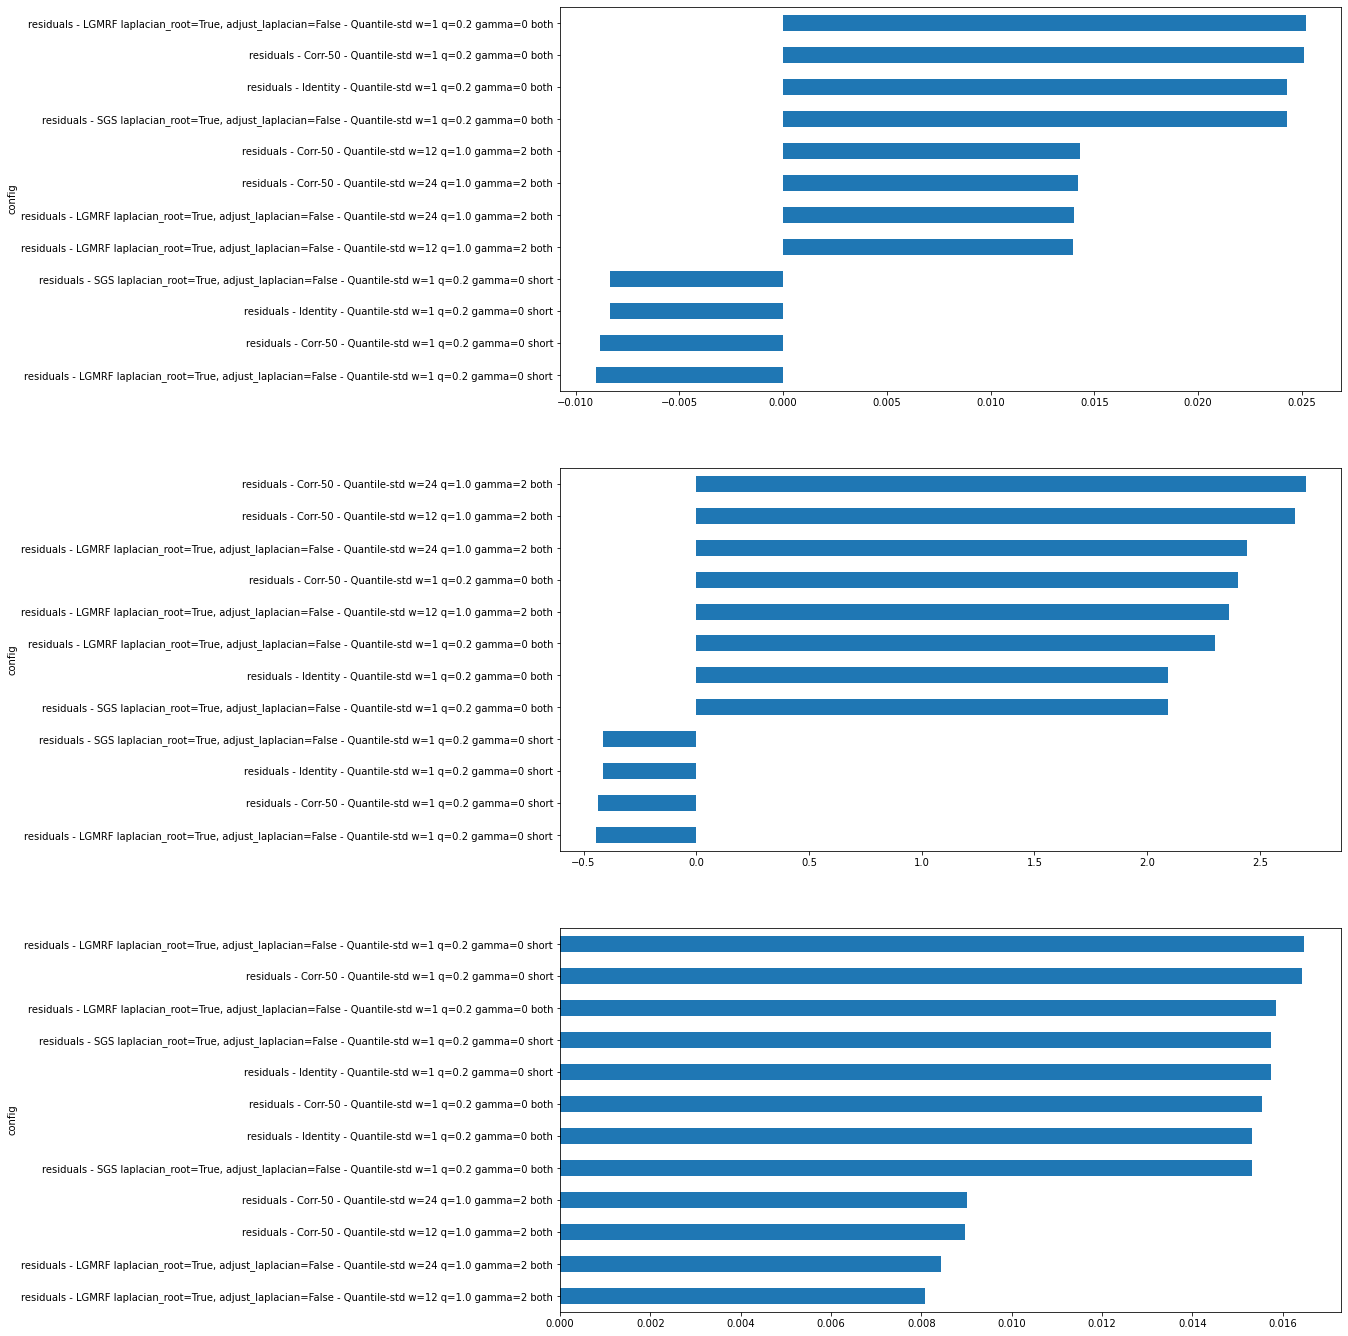

In [24]:
fig, axs = plt.subplots(3, figsize=(14, 24))
grouped_split_results = split_returns_df[split_returns_df['config'].isin(top_configs) & (split_returns_df['benchmark'] == False)].groupby('config')['avg_month_returns']
grouped_split_results.mean().sort_values(ascending=True).plot.barh(x='config', y='avg_month_returns', ax=axs[0])
(grouped_split_results.mean() / grouped_split_results.std() * np.sqrt(12)).sort_values(ascending=True).plot.barh(x='config', y='avg_month_returns', ax=axs[1])
trading_alphas[top_configs].sort_values(ascending=True).plot.barh(ax=axs[2])

In [ ]:
split_results_df = pd.concat(split_results_list)
split_results_df['date'] = pd.to_datetime(split_results_df['date'].str[:4] + '-' + split_results_df['date'].str[4:] + '-01')
split_results_df['window'] = split_results_df['w'].astype(str)
split_results_df['quantile'] = split_results_df['q'].astype(str)
split_results_df['index'] += 1
# split_results_df = split_results_df[(split_results_df['w'] != 24).values]
split_results_df

In [ ]:
mean_split_results_df = split_results_df.groupby(['date', 'q', 'w', 'trading_type', 'benchmark'])['avg_month_returns'].mean().reset_index()
clean_split_results_df = []
for i, g in mean_split_results_df.groupby(['q', 'w', 'trading_type', 'benchmark']):
    g = g.sort_values('date')
    g['cumulative_monthly_returns'] = g['avg_month_returns'].cumsum()
    clean_split_results_df.append(g)
clean_split_results_df = pd.concat(clean_split_results_df)
clean_split_results_df

In [ ]:
set(['a', 'a', 'b', 'c', 'b'])

In [ ]:
sns.relplot(data=clean_split_results_df, x='date', y='cumulative_monthly_returns', 
            hue='trading_type', style='benchmark', 
            row='w', col='q', kind='line', height=3, aspect=3)
plt.show()

In [ ]:
sns.relplot(data=clean_split_results_df, x='w', y='avg_month_returns', 
            row='trading_type', col='q', 
            hue='benchmark', kind='line', height=3, aspect=2)
plt.show()

In [ ]:
grouped_split_results = clean_split_results_df.groupby(['q', 'w', 'trading_type', 'benchmark'])['avg_month_returns']
# fig, axs = plt.subplots(3, figsize=(16, 15))

sns.relplot(data=(grouped_split_results.mean()).reset_index(),
                x='w', y='avg_month_returns', hue='q', col='trading_type', style='benchmark', palette='husl', kind='line')
plt.show()
sns.relplot(data=(grouped_split_results.std()).reset_index(),
                x='w', y='avg_month_returns', hue='q', col='trading_type', style='benchmark', palette='husl', kind='line')
plt.show()
sns.relplot(data=(grouped_split_results.mean() / grouped_split_results.std() * np.sqrt(12)).reset_index(),
                x='w', y='avg_month_returns', hue='q', col='trading_type', style='benchmark', palette='husl', kind='line')
plt.show()

In [ ]:
# %%time
# train_spreads, test_spreads, L, L_sqrt = compute_spreads(train_residuals, test_residuals, laplacian_root=False, reltol=2.5e-4)
# pd.DataFrame({'train': np.abs(np.sign(train_spreads.cumsum()).diff() / 2).sum().round(), 
#               'test': np.abs(np.sign(test_spreads.cumsum()).diff() / 2).sum().round()}).plot.hist(bins=40, alpha=.4)
# pd.DataFrame({'train': np.abs(np.sign(train_spreads.cumsum()).diff() / 2).sum().round(), 
#               'test': np.abs(np.sign(test_spreads.cumsum()).diff() / 2).sum().round()}).mean()